## Travel times in 2D heterogenous media: Borehole example  #

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyfm2d
import time
from tqdm import tqdm

--------

## Fast Marching Wave Front Tracking


The wave front tracker routines solves boundary value ray tracing problems into 2D heterogeneous wavespeed media, defined by continuously varying velocity model calculated by 2D cubic B-splines.

Follows similar structure and makes use of code borrowed from Andrew Valentine's rayTracer.py.

#### Utility routines for building velocity models

In [2]:
# build test velocity models
from scipy.stats import multivariate_normal

def get_spherical_model(extent,nx,ny): # build two spherical anomaly velocity model
    # set up velocity model
    vc1 = 1700                                              # velocity of circle 1 in m/s
    vc2 = 2300                                              # velocity of circle 2 in m/s
    c1,rad1 = np.array([7.0,22.]),3.0                       # location and radius of centre of first circle
    c2,rad2 = np.array([12.0,10.]),4.0                      # location and radius of centre of first circle
    #nx,ny = 32,48                                          # model discretization
    mb = 2000.*np.ones([nx,ny])                             # velocity model in m/s
    dx = (extent[1]-extent[0])/nx                           # cell width
    dy = (extent[3]-extent[2])/ny                           # cell height
    xc = np.linspace(extent[0]+dx/2.,extent[1]-dx/2.,nx)    # cell centre
    yc = np.linspace(extent[2]+dy/2.,extent[3]-dy/2.,ny)    # cell centre
    X,Y = np.meshgrid(xc, yc)   # cell centre mesh
    m = np.copy(mb)
    a = (X-c1[0])**2 + (Y-c1[1])**2 < rad1**2
    m[a.T] = vc1
    b = (X-c2[0])**2 + (Y-c2[1])**2 < rad2**2
    m[b.T] = vc2
    return m

def get_gauss_model(extent,nx,ny,factor=1.): # build two gaussian anomaly velocity model
    vc1 = 1700*factor                           # velocity of circle 1 in m/s
    vc2 = 2300*factor                           # velocity of circle 2 in m/s
    vb = 2000*factor                            # background velocity
    dx = (extent[1]-extent[0])/nx               # cell width
    dy = (extent[3]-extent[2])/ny               # cell height
    xc = np.linspace(extent[0],extent[1],nx)    # cell centre
    yc = np.linspace(extent[2],extent[3],ny)    # cell centre
    X,Y = np.meshgrid(xc, yc,indexing='ij')     # cell centre mesh

    # Multivariate Normal
    dex = extent[1]-extent[0]
    dey = extent[3]-extent[2]
    c1x = extent[0] + (7.0-extent[0])*dex/20.
    c2x = extent[0] + (12.0-extent[0])*dex/20.
    c1y = extent[0] + (22.0-extent[0])*dey/30.
    c2y = extent[0] + (10.0-extent[0])*dey/30.
    s1 = 6.0*dex/20.
    s2 = 10.0*dex/20.
    c1,sig1 = np.array([c1x,c1y])*factor,s1*(factor**2)      # location and radius of centre of first circle
    c2,sig2 = np.array([c2x,c2y])*factor,s2*(factor**2)      # location and radius of centre of first circle
    rv1 = multivariate_normal(c1, [[sig1, 0], [0, sig1]])
    rv2 = multivariate_normal(c2, [[sig2, 0], [0, sig2]])

    # Probability Density
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    gauss1,gauss2 = rv1.pdf(pos),rv2.pdf(pos)
    return   vb*np.ones([nx,ny])  + (vc1-vb)*gauss1/np.max(gauss1) + (vc2-vb)*gauss2/np.max(gauss2)


----

### Specifying a velocity model

Velocity or Slowness models should be provided in the form of a 2D NumPy array, which specify the *velocity* structure at 'nodes' within a 2D medium. A cubic B-spline velocity model is then constructed about these nodal velocities to give a smoothly varying velocity field throughout the medium. To define the model we create an instance of the class `pyfm2d.BasisModel`, passing our model as an argument:

Internally the velocity model is `diced` (interpolated) onto a finer grid of `8x8` (default) cells per velocity node. 
The latter is used for Fast Marching calculations. The discretization levels `(dicex,dicey)` are options that can be changed in the call to `BasisModel`.  For a cubic interpolation there must be at least 4 velocity nodes in each direction.


In [3]:
# a simple example of a 4x4 velocity model
m = np.array(
    [
        [1, 1.1, 1.1, 1.0],
        [1.0, 1.2, 1.4, 1.3],
        [1.1, 1.2, 1.3, 1.2],
        [1.1, 1.1, 1.2, 1.2],
    ]
)
g = pyfm2d.BasisModel(m)

To access and change the model subsequently, the `pyfm2d.BasisModel` object provides functions `get_velocity()`, `get_slowness()`, `set_velocity(v)` and `set_slowness(s)`. For example:

In [4]:
mp = g.get_velocity()
mp[1,1] = 0.7
mp[2,2] = 0.9
mp[2,1] = 1.3
g.set_velocity(mp)
g.get_slowness()

array([[1.        , 0.90909091, 0.90909091, 1.        ],
       [1.        , 1.42857143, 0.71428571, 0.76923077],
       [0.90909091, 0.76923077, 1.11111111, 0.83333333],
       [0.90909091, 0.90909091, 0.83333333, 0.83333333]])

The routine `pyfm2d.display_model` can be used to plot the model. By default the actual interpolated velocity model is displayed by `display_model`, but this can be removed with option `dice=False`.


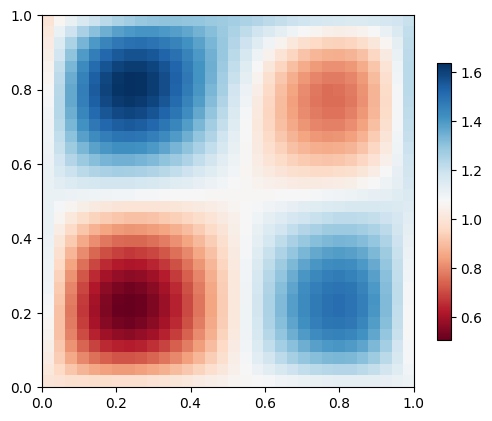

In [5]:
velocity = g.get_velocity()
pyfm2d.display_model(velocity)

### Fast Marching wavefront tracking
 
The method used here is *Fast Marching wavefront tracking*. In this algorithm the entire first arriving wavefronts from each source are calculated across the entire model in the form of a *travel time field* one per source. Travel times and ray paths are then calculated by tracing rays back from a desired receiver position to the source along the perpendicular to the wavefronts. This uses the *Fast Marching method* which is stable in highly heterogeneous velocity models. Here we implement a version of Fast Marching with source grid refinement for improved accuracy, as described in the papers below. 

*Rawlinson, N., de Kool, M. and Sambridge, M., 2006. "Seismic wavefront tracking in 3-D heterogeneous media: applications with multiple data classes", Explor. Geophys., 37, 322-330.*

*de Kool, M., Rawlinson, N. and Sambridge, M. 2006. "A practical grid based method for tracking multiple refraction and reflection phases in 3D heterogeneous media", Geophys. J. Int., 167, 253-270.*

The python implementation here is a *wrapper* around the FMM code `fm2dss.f90` of Nick Rawlinson using `ctypes`.

-------

First we set up a single source and receiver.

In [6]:
srcs = np.array([0.1,0.15])

In [7]:
recs = np.array([[0.8,1],[1.,0.6]])

#### Calling sequence

The wavefront tracker is implemented with a single function called `pyfm2d.calc_wavefronts(vmodel,recs,srcs)` which calculates all first arriving travel times between sources, `srcs` and receivers, `recs` for velocity model `vmodel`. (Travel time is set to zero if no path is found.)  Optionally you can set the `extent` of the domanin as `extent=[xmin, xmax, ymin, ymax]`.

Configuration options that are passed to the lower level Fortran code are contained in a `pyfm2d.WaveTrackerOptions` object

  The main optional configurations are:
  
  - `paths = True` to return ray paths
  - `frechet = True` to return matrix of derivatives of travel times with respect to input velocities.
  - `ttfield_source = i`, to return first arriving travel time field for ith source.
  - `cartesian = True`, to use a Cartesian framework, with input spatial co-ordinates in kms.
     Otherwise a spherical system is used with input co-ordinates in degrees (long,lat).
                    
       Many other arguments exist which allow complete control of the Fast Marching algorithm. Details can be found in the doc string. A full implementation would be
       
        import pyfm2d
        options = pyfm2d.WaveTrackerOptions(frechet=True, paths=True, ttfield_source=0)
        result = pyfm2d.calc_wavefronts(vmodel,recs,srcs,options=options)
           
`result` is a `pyfm2d.WaveTrackerResult` object, which will have the set attributes `fmm.ttimes` for travel times; `paths` for ray paths; `frechet` for matrix of derivatives (in `csr_matrix` format); `ttfield` for travel time field of source `ttfield_source`.

In [8]:
# run wave front tracker
options = pyfm2d.WaveTrackerOptions(
    frechet=True,
    paths=True,
    cartesian=True,
)
result = pyfm2d.calc_wavefronts(velocity,recs,srcs,options=options)
print(' Number of paths calculated = ',len(result.paths))
print(' Number of travel times calculated = ',len(result.ttimes))
print(' Shape of frechet matrix = ',result.frechet.shape)

 Number of paths calculated =  2
 Number of travel times calculated =  2
 Shape of frechet matrix =  (2, 16)


To plot models, you can use the function `pyfm2d.display_model`. This takes the form:
```python
display_model(model,paths,extent,clim,cline,cmap,figsize,wfront,**kwargs)
```
but only the first argument is essential; the others are all optional. Their meanings are:
- `model` is the 2-D array containg the attenuation coefficients in each cell
- `paths` is the 2-D array of path information in the same form as for `xrt.tracer`. We recommend you do not use this option if you have more than a modest number of paths (a few tens) as it will be slow to plot and difficult to see anything useful.
- `extent` specifies the region of space for which the model is defined, in the format `(xmin,xmax,ymin,ymax)`; by default this is `(0,1,0,1)`.
- `clim` sets the range of the colour-scale; use `clim=(min,max)`. By default this is inferred from the model provided.
- `cline` sets the colour of the ray paths (default 'k').
- `cmap` sets the colour map; provide one of the many choices provided within `matplotlib` (accessed within `plt.cm`, e.g. `cmap=plt.cm.RdBu_r`)
- `figsize` allows you to control the size of the figure: provide `figsize=(xsize,ysize)`.
-  `wfront` is a 2-D array of first arriving travel times to all points in the model from a given source that can be contoured to visualize a wavefront. Here the input array can be calculated by the `wavefront_tracker()` routine for a specified source.
- if `wfront` is used then any remaining `kwargs` are passed to `matplotlib.pyplot.contour()` to control features of all wavefronts).

For example,

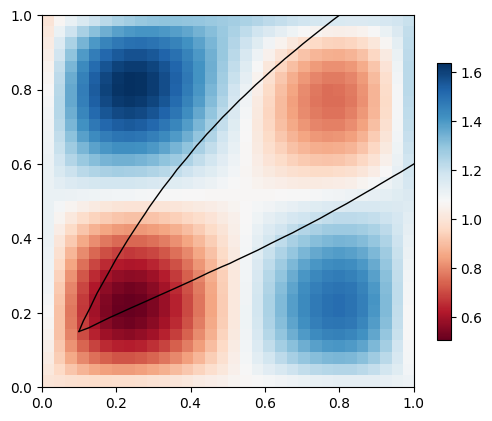

In [9]:
pyfm2d.display_model(velocity, paths=result.paths, diced=True)

Let's try a different source-receiver configuration.

In [10]:
# run wave front tracker
recs = pyfm2d.wavetracker.generate_surface_points(8)

options = pyfm2d.WaveTrackerOptions(
    frechet=True,
    paths=True,
    cartesian=True,
    ttfield_source=0
)
result = pyfm2d.calc_wavefronts(velocity,recs,srcs,options=options)
print(' Number of paths calculated = ',len(result.paths))
print(' Number of travel times calculated = ',len(result.ttimes))
print(' Shape of frechet matrix = ',result.frechet.shape)

 Number of paths calculated =  36
 Number of travel times calculated =  36
 Shape of frechet matrix =  (36, 16)


The routine `displayModel` is able to optionally overlay wavefronts for a single source produced by the wavefront tracker.

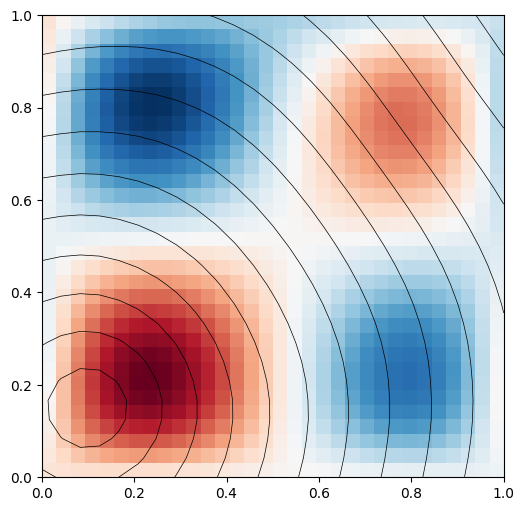

In [11]:
pyfm2d.display_model(
    velocity,
    wfront=result.ttfield,
    alpha=0.5,
    colors="k",
    linewidths=0.5,
    levels=np.linspace(0.01, 1.2, 16),
)


----

### Example: Cross borehole velocity model

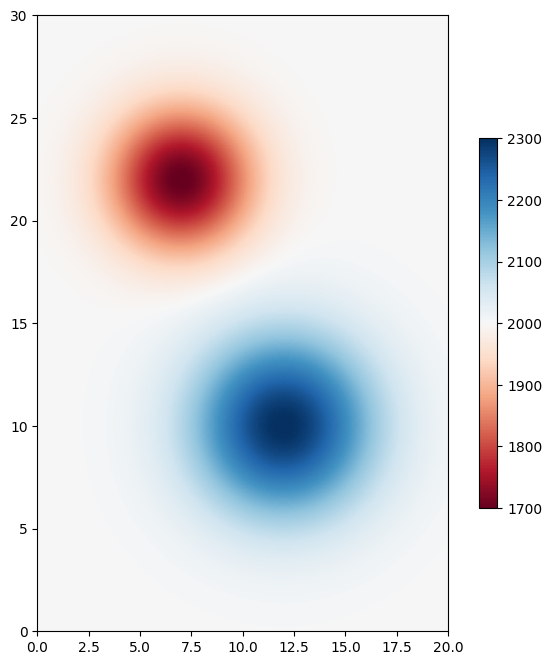

In [12]:
extent = [0.0, 20.0, 0.0, 30.0]
m = get_gauss_model(extent, 32, 48)
g2 = pyfm2d.BasisModel(m, extent=extent)
velocity = g2.get_velocity()
pyfm2d.display_model(velocity, extent=extent, figsize=(8, 8), clim=(1700, 2300))

In [13]:
# build sources and receivers for model 2
# create 10 sources of left and 10 receiver on right
recs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=extent, surface=[False, True, False, False], addCorners=False
)  # generate receivers around edge
srcs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=extent, surface=[True, False, False, False], addCorners=False
)  # generate receivers around edge
nr = len(recs)  # number of receivers
ns = len(recs)  # number of sources

In [14]:
# run wave front tracker
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=True,
    paths=True,
    cartesian=True,
)

result = pyfm2d.calc_wavefronts(velocity, recs, srcs, extent=extent, options=options)
print(" Number of paths calculated = ", len(result.paths))
print(" Number of travel times calculated = ", len(result.ttimes))
print(" Shape of frechet matrix = ", result.frechet.shape)

 Number of paths calculated =  100
 Number of travel times calculated =  100
 Shape of frechet matrix =  (100, 1536)


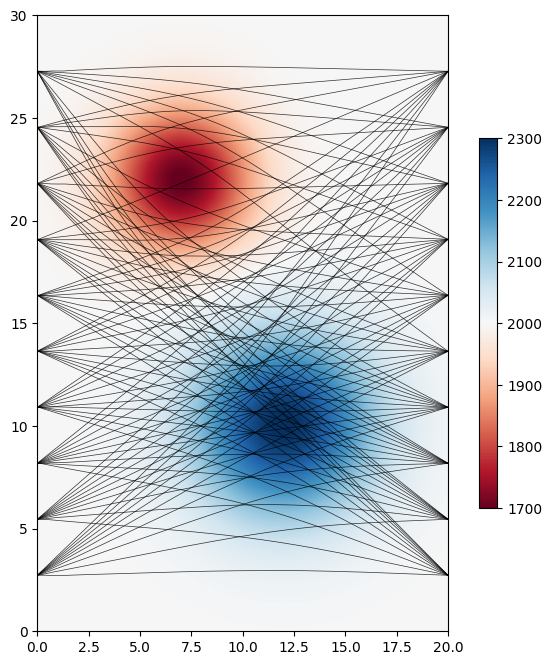

In [15]:
pyfm2d.display_model(
    velocity,
    paths=result.paths,
    extent=extent,
    figsize=(8, 8),
    clim=(1700, 2300),
    line=0.5,
    alpha=0.8,
)

### Example: Cross borehole continuous

In [16]:
extent = [0.0, 20.0, 0.0, 30.0]
g3 = pyfm2d.BasisModel(np.loadtxt("datasets/cbmod.txt"), extent=extent)
velocity = g3.get_velocity()
#pyfm2d.display_model(velocity, extent=extent, figsize=(8, 8), clim=(1700, 2300))

In [17]:
velocity

array([[2261.67957296, 2209.38082611, 2164.49343554, ..., 1970.81421531,
        1962.55821405, 1956.17385786],
       [2195.52453484, 2159.68615642, 2127.69444653, ..., 1976.96170022,
        1969.98574794, 1964.34502872],
       [2137.65487581, 2116.53584218, 2094.68297741, ..., 1982.92199154,
        1977.53134288, 1973.79102785],
       ...,
       [2309.33102969, 2268.03944716, 2231.81606644, ..., 1874.69144589,
        1850.24324806, 1826.8135537 ],
       [2395.76713487, 2341.82379973, 2294.02898276, ..., 1848.12219001,
        1817.13397846, 1788.58269961],
       [2493.74103577, 2423.25367392, 2359.4461805 , ..., 1820.89840083,
        1784.60968816, 1750.26377228]], shape=(32, 48))

In [18]:
# build sources and receivers for model 2
# create 10 sources of left and 10 receiver on right
recs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=extent, surface=[False, True, False, False], addCorners=False
)  # generate receivers around edge
srcs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=extent, surface=[True, False, False, False], addCorners=False
)  # generate receivers around edge
nr = len(recs)  # number of receivers
ns = len(recs)  # number of sources

### Ray paths and wavefronts

In [19]:
# calculate an plot ray paths and wavefronts
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=True,
    paths=True,
    cartesian=True,
    ttfield_source=5,  # select a source index to calculate and display wavefronts.
)

result = pyfm2d.calc_wavefronts(velocity, recs, srcs, extent=extent, options=options)
print(" Number of sources                 = ", ns)
print(" Number of receivers               = ", nr)
print(" Number of paths calculated        = ", len(result.paths))
print(" Number of travel times calculated = ", len(result.ttimes))
print(" Shape of frechet matrix           = ", result.frechet.shape)

 Number of sources                 =  10
 Number of receivers               =  10
 Number of paths calculated        =  100
 Number of travel times calculated =  100
 Shape of frechet matrix           =  (100, 1536)


Display velocity model and all two-point ray paths.

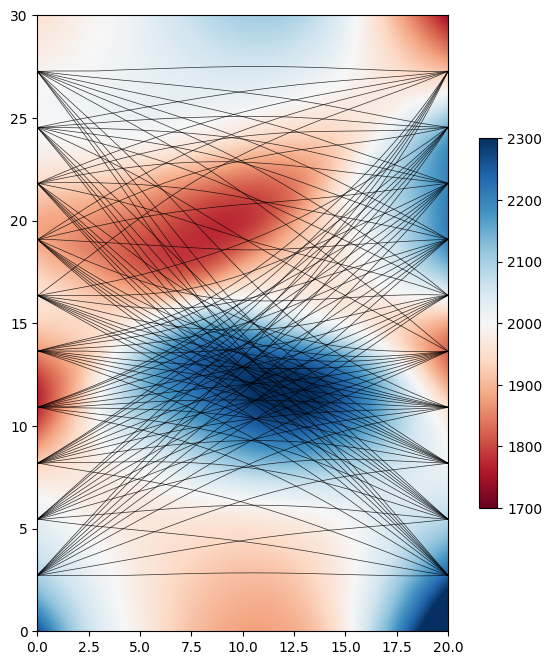

In [20]:
pyfm2d.display_model(
    velocity,
    paths=result.paths,
    extent=extent,
    figsize=(8, 8),
    clim=(1700, 2300),
    line=0.5,
    cline="k",
    alpha=0.8,
)

Display velocity model, rays and wavefronts for chosen source.

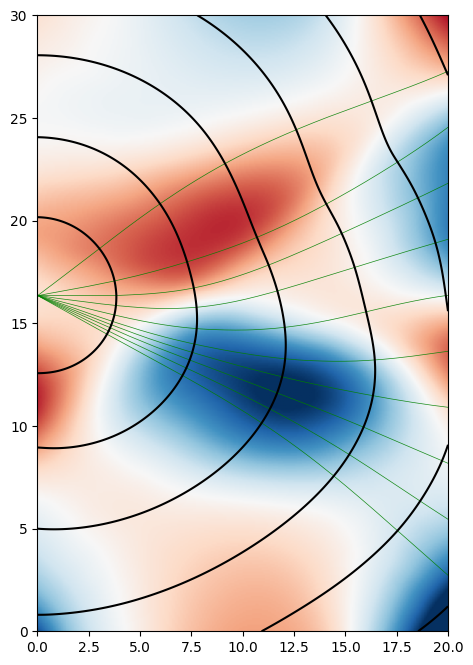

In [21]:
pyfm2d.display_model(
    velocity,
    paths=result.paths[ns * options.ttfield_source : ns * options.ttfield_source + nr],
    clim=(1700, 2300),
    extent=extent,
    figsize=(8, 8),
    cline="g",
    alpha=0.9,
    line=0.5,
    wfront=result.ttfield,
    colors="k",
)

----

### A test of computation time

Here is a simple repeat of `calc_wavefronts` to test compute times.

In [22]:
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=True,
    paths=True,
    cartesian=True,
)
n = 10  # number of repeats
start = time.time()
for i in tqdm(range(n)):
    result = pyfm2d.calc_wavefronts(g2.get_velocity(),recs,srcs,extent=extent,options=options)
etime1 = time.time() - start
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=False,
    paths=True,
    cartesian=True,
)
lp = len(result.paths)
start = time.time()
for i in tqdm(range(n)):
    result = pyfm2d.calc_wavefronts(g2.get_velocity(),recs,srcs,extent=extent,options=options)
etime2 = time.time() - start
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=False,
    paths=False,
    cartesian=True,
)
start = time.time()
for i in tqdm(range(n)):
    result = pyfm2d.calc_wavefronts(g2.get_velocity(),recs,srcs,extent=extent,options=options)
etime3 = time.time() - start
print(' Number of sources                 = ',ns)
print(' Number of receivers               = ',nr)
print(' Number of paths calculated        = ',lp)
print(' Number of travel times calculated = ',len(result.ttimes))
print(' Average compute time perfromed over {} trials                    '.format(n))
print(' Average compute time just travel times:                    {:.3}s'.format(etime3/n))
print(' Average compute time for times and raypaths:               {:.3}s'.format(etime2/n))
print(' Average compute time for times, raypaths & frechet matrix: {:.3}s'.format(etime1/n))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.36it/s]

 Number of sources                 =  10
 Number of receivers               =  10
 Number of paths calculated        =  100
 Number of travel times calculated =  100
 Average compute time perfromed over 10 trials                    
 Average compute time just travel times:                    0.157s
 Average compute time for times and raypaths:               0.366s
 Average compute time for times, raypaths & frechet matrix: 0.375s
